In [1]:
import os, pickle, cPickle, sys, urllib, gzip

In [2]:
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [3]:
from lasagne.layers import InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import tanh
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet, BatchIterator

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print 'Using cuda_convnet (faster)'
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print 'Using lasagne.layers (slower)'

Using cuda_convnet (faster)


In [5]:
### when we load the batches to input to the neural network, we randomly / flip rotate the images, to artificially
### increase the size of the training set

class FlipBatchIterator(BatchIterator):

    def transform(self, X1, X2):
        X1b, X2b = super(FlipBatchIterator, self).transform(X1, X2)
        X2b = X2b.reshape(X1b.shape)

        bs = X1b.shape[0]
        h_indices = np.random.choice(bs, bs / 2, replace=False) # horizontal flip
        v_indices = np.random.choice(bs, bs / 2, replace=False) # vertical flip
        
        ###  uncomment these lines if you want to include rotations (images must be square)  ###
        #r_indices = np.random.choice(bs, bs / 2, replace=False) # 90 degree rotation
        for X in (X1b, X2b):
            X[h_indices] = X[h_indices, :, :, ::-1]
            X[v_indices] = X[v_indices, :, ::-1, :]
            #X[r_indices] = np.swapaxes(X[r_indices, :, :, :], 2, 3)
        shape = X2b.shape
        X2b = X2b.reshape((shape[0], -1))

        return X1b, X2b

In [6]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
X, y = train_set
X = np.rint(X * 256).astype(np.int).reshape((-1, 1, 28,28)) # convert to (0,255) int range (we'll do our own scaling)
mu, sigma = np.mean(X.flatten()), np.std(X.flatten())

In [7]:
X_train = X.astype(np.float64)
X_train = (X_train - mu) / sigma
X_train = X_train.astype(np.float32)

# we need our target to be 1 dimensional
X_out = X_train.reshape((X_train.shape[0], -1))

In [8]:
conv_num_filters = 32
conv_filter_size = 7
pool_size = 2
deconv_filters = 32
epochs = 20
encode_size = 40
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': conv_filter_size, 'nonlinearity': None}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}), # not sure if necessary?
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': deconv_filters * (28 + conv_filter_size - 1) ** 2 / 4}),
    (ReshapeLayer, {'shape': (([0], deconv_filters, (28 + conv_filter_size - 1) / 2, (28 + conv_filter_size - 1) / 2 ))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': conv_filter_size, 'nonlinearity': None}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [9]:
ae = NeuralNet(
    layers=layers,
    max_epochs=epochs,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    regression=True,
    verbose=1
)

In [10]:
ae.fit(X_train, X_out)
print 
###  expect training / val error of about 0.087 with these parameters
###  if your GPU not fast enough, reduce the number of filters in the conv/deconv step

# Neural Network with 537257 learnable parameters

## Layer information

  #  name          size
---  ------------  --------
  0  input0        1x28x28
  1  conv2dcc1     32x22x22
  2  maxpool2dcc2  32x11x11
  3  reshape3      3872
  4  encode        40
  5  dense5        9248
  6  reshape6      32x17x17
  7  upscale2d7    32x34x34
  8  conv2d8       1x28x28
  9  reshape9      784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.42793       0.21328      2.00647  11.05s
      2       0.17378       0.14758      1.17751  11.02s
      3       0.13602       0.12634      1.07664  11.03s
      4       0.12152       0.11637      1.04425  11.04s
      5       0.11364       0.11070      1.02658  11.14s
      6       0.10870       0.10651      1.02059  11.19s
      7       0.10528       0.10385      1.01376  11.19s
      8       0.10233       0.10110      1.01217  11.18s
      9       0.10007       0.09894      1.01151

In [11]:
import pickle
import sys
sys.setrecursionlimit(10000)

pickle.dump(ae, open('mnist/conv_ae.pkl','w'))
#ae = pickle.load(open('mnist/conv_ae.pkl','r'))
ae.save_params_to('mnist/conv_ae.np')

In [12]:
X_train_pred = ae.predict(X_train).reshape(-1, 28, 28) * sigma + mu
X_pred = np.rint(X_train_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print X_pred.shape , X.shape

(50000, 28, 28) (50000, 1, 28, 28)


In [13]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


4720


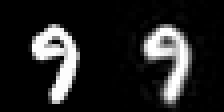

In [14]:
###  show random inputs / outputs side by side

def get_picture_array(X, index):
    array = X[index].reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(4, axis = 0).repeat(4, axis = 1).astype(np.uint8())

def get_random_images():
    index = np.random.randint(5000)
    print index
    original_image = Image.fromarray(get_picture_array(X, index))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred, index))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")    
    
get_random_images()
IPImage('data/test.png')

In [20]:
from lasagne.layers import get_output
## we find the encode layer from our ae, and use it to define an encoding function

encode_layer_index = 4
encode_layer = ae.get_all_layers()[encode_layer_index]

def get_output_from_nn(last_layer, X):
    indices = np.arange(128, X.shape[0], 128)
    sys.stdout.flush()
    
    # not splitting into batches can cause a memory error
    X_batches = np.split(X, indices)
    out = []
    for count, X_batch in enumerate(X_batches):
        out.append(get_output(last_layer, inputs=X_batch).eval())
        sys.stdout.flush()
    return np.vstack(out)


def encode_input(X):
    return get_output_from_nn(encode_layer, X)

X_encoded = encode_input(X_train)

(50000, 784)


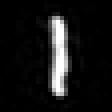

In [21]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = decode_encoded_input(X_encoded) * sigma + mu

X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print X_decoded.shape

### check it worked :

pic_array = get_picture_array(X_decoded, np.random.randint(len(X_decoded)))
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')